# Muse EEG

Muse 2 is a headset that measures EEG signals from 4 locations on the surface of the skull. These signals are `TP9`, `TP10`, `AF7`, and `AF8`.

This naming system is called the 10/10 system. It is a global standard for locations where EEG electrodes are placed on the head for reading EEG data, as show in the image below.

![EEG 10/10 system](./data/EEG-10-10.png)

As we can see from the image, two of the sensors (`TP9`, `TP10`) are located on the frontal lobe, while the other two (`AF7`, `AF8`) is located on the temporal lobe. Given this, we would expect sensors with the same prefix to have similar outputs.

The output from the sensors comes as point-in-time samples of the current reading. We want to process this input and train ML models to associate brain waves with specific *behaviors, events, and emotions*. At the end of this project, we will be able to predict the behavior or emotion of a person in real time using their brainwaves.

First, we can define some data processing functions to help us understand the raw EEG samples.

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.signal as ss
import seaborn as sns
import matplotlib.pyplot as plt

# Sample rate of Muse 2
DEFAULT_SAMPLE_RATE = 256

def preprocess_eeg(data):
    """
    Apply transformations that we want for most EEG data.
    - Remove 60 Hz noise
    - Detrend
    """
    
    # Remove 60 Hz noise
    b, a = ss.iirnotch(60.0, 200.0, 200.)
    data_ret = ss.filtfilt(b, a, data)
    # Detrend (REMOVE?)
    data_ret = ss.detrend(data_ret)
    return data_ret

# Define EEG bands
eeg_bands = {'Delta': (0, 4),
             'Theta': (4, 8),
             'Alpha': (8, 12),
             'Beta': (12, 30),
             'Gamma': (30, 50)}
# Colors to use when plotting
band_colors = {
    'Delta': 'tab:blue',
    'Theta': 'tab:orange',
    'Alpha': 'tab:gray',
    'Beta': 'tab:green',
    'Gamma': 'tab:brown'
}

def get_band_magnitudes(data, sample_rate=DEFAULT_SAMPLE_RATE):
    """
    Given an EEG timeseries, compute the magnitude of each band of EEG frequencies.
    """
    
    # Get real amplitudes of FFT (only in postive frequencies)
    fft_vals = np.absolute(np.fft.rfft(data))

    # Get frequencies for amplitudes in Hz
    fft_freq = np.fft.rfftfreq(len(data), 1.0/sample_rate)

    # Take the mean of the fft amplitude for each EEG band
    eeg_band_fft = dict()
    for band in eeg_bands:
        freq_ix = np.where((fft_freq >= eeg_bands[band][0]) &
                           (fft_freq <= eeg_bands[band][1]))[0]
        eeg_band_fft[band] = np.mean(fft_vals[freq_ix])
    
    return eeg_band_fft

#### Plot magnitude of each band over time

def band_magnitude_samples(data, frame_size=None, sample_rate=DEFAULT_SAMPLE_RATE):
    """
    Get the magnitude of each frequency band over time, using frames of a given size.
    """
    
    # Default to 2s per frame
    if frame_size == None:
        frame_size = int(sample_rate * 2)
    max_frame = len(data)
    frame_count = int(np.ceil(max_frame / frame_size))

    bands_over_time = {
        'Delta': [],
        'Theta': [],
        'Alpha': [],
        'Beta': [],
        'Gamma': []
    }
    band_keys = list(bands_over_time.keys())

    for frame_i in range(0, frame_count):
        start_frame = frame_i * frame_size
        bands = get_band_magnitudes(data[start_frame:start_frame+frame_size], sample_rate=sample_rate)
        for band_key in band_keys:
            bands_over_time[band_key].append(bands[band_key])

    # Process into numpy arrays
    for band_key in band_keys:
        bands_over_time[band_key] = np.array(bands_over_time[band_key])
        
    return bands_over_time

def plot_band_magnitude(data, frame_size=None, sample_rate=DEFAULT_SAMPLE_RATE, start_time=0, end_time=1):
    bands_over_time = band_magnitude_samples(data, frame_size, sample_rate)
    frame_count = len(bands_over_time["Delta"])

    # Plot each band
    for band_key in bands_over_time.keys():
        band = bands_over_time[band_key]
        plt.plot(np.linspace(start_time, end_time, frame_count), band, color=band_colors[band_key], label=band_key)

    plt.legend()
    plt.show()

In [4]:
muse_session_lsd_postpeak = pd.read_csv("./data/muse2-recordings/jared/recording_2021-06-10-08.30.37.csv")
muse_session_lsd_postpeak

,Unnamed: 0,TP9,AF7,AF8,TP10,Right AUX,timestamps
0,0,0.000,0.000,0.000,0.000,0.0,1.623314e+09
1,1,0.000,0.000,-11.230,0.000,0.0,1.623314e+09
2,2,-1.465,-1.953,27.832,-1.953,0.0,1.623314e+09
3,3,2.441,2.441,-74.219,3.418,0.0,1.623314e+09
4,4,-12.695,-15.625,129.883,-17.090,0.0,1.623314e+09
...,...,...,...,...,...,...,...
15355,15355,-27.832,-48.340,-236.328,-25.391,0.0,1.623314e+09
15356,15356,-31.250,-56.152,-280.273,-23.438,0.0,1.623314e+09
15357,15357,-24.414,-49.805,-202.637,-27.832,0.0,1.623314e+09
15358,15358,-22.949,-44.434,-129.883,-37.109,0.0,1.623314e+09


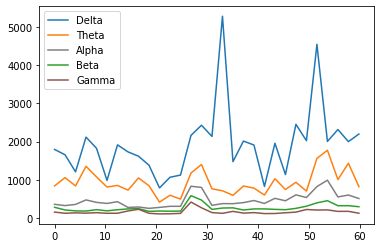

In [3]:
muse_session_lsd_postpeak_duration = muse_session_lsd_postpeak["timestamps"].iloc[-1] - muse_session_lsd_postpeak["timestamps"].iloc[0]
plot_band_magnitude(preprocess_eeg(muse_session_lsd_postpeak["AF7"]), start_time=0, end_time=muse_session_lsd_postpeak_duration)

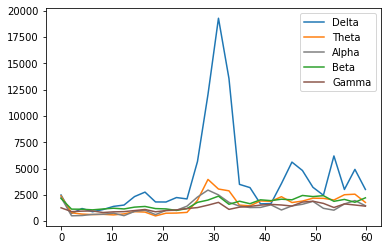

In [4]:
plot_band_magnitude(preprocess_eeg(muse_session_lsd_postpeak["AF8"]), start_time=0, end_time=muse_session_lsd_postpeak_duration)

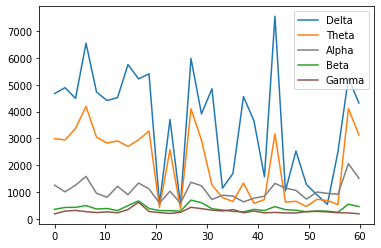

In [5]:
plot_band_magnitude(preprocess_eeg(muse_session_lsd_postpeak["TP9"]), start_time=0, end_time=muse_session_lsd_postpeak_duration)

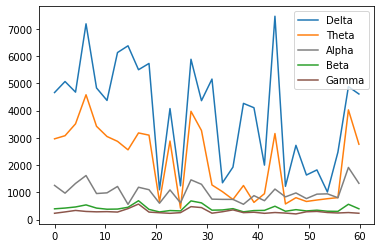

In [6]:
plot_band_magnitude(preprocess_eeg(muse_session_lsd_postpeak["TP10"]), start_time=0, end_time=muse_session_lsd_postpeak_duration)

As expected, the sensors on opposite sides of the head product similar signals - there is a high degree of covariance in the band magnitudes of both `TP9` and `TP10`, and `AF7` and `AF8`.

# Streaming Sensor Data

We will use `pylsl` to connect to Muse 2.

In [136]:
import pylsl as lsl
import sys

streams = lsl.resolve_byprop('type', 'EEG', timeout=2)

if len(streams) == 0:
    print("ERROR: no Muse devices found. Make sure `muselsl stream` is running.", file=sys.stderr)
else:
    print("Successfully connected to muse device")
    muse_stream = streams[0]

muse_inlet = lsl.StreamInlet(muse_stream, max_chunklen=11)

# Print time correction (lag?)
muse_time_correction = muse_inlet.time_correction()
print("Time correction:", muse_time_correction)

# Get the stream info and description
info = muse_inlet.info()
description = info.desc()

# Get sample rate
muse_sample_rate = int(info.nominal_srate())
print("Sample rate:", muse_sample_rate)

Successfully connected to muse device
Time correction: -1.1328986147418618e-05
Sample rate: 256


## Live Frequency Plot

Now that we are connected, we will read chunks of from the stream and graph the magnitude of each brainwave frequency band over time.

<IPython.core.display.Javascript object>


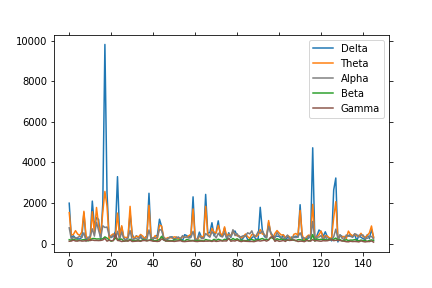

61440 37376


('./data/muse2-recordings/jared/eeg_raw_test-2021-06-21 01:05:44.681606.csv',
 './data/muse2-recordings/jared/eeg_band_magnitudes_test-2021-06-21 01:05:44.681606.csv')

In [161]:
%matplotlib notebook
import datetime
import time

def stream_muse_samples(delta):
    start_time = datetime.datetime.now()
    end_time = datetime.datetime.now() + delta
    timestamp = str(start_time)

    # Record and display 30s of EEG data
    while datetime.datetime.now() < end_time:
        # Get raw EEG data
        sample_matrix, timestamps = muse_inlet.pull_chunk(timeout=1, max_samples=muse_sample_rate)
        sample_matrix = np.array(sample_matrix)
        # Get time
        time_delta = (datetime.datetime.now() - start_time).total_seconds()

        # Add time to raw sample
        sample_matrix = np.append(sample_matrix, np.full((sample_matrix.shape[0], 1), time_delta), axis=1)
        # Add raw sample to sample list
        yield sample_matrix

def save_and_plot_muse_sample_stream(delta, tag=None, output_path=None):
    if output_path is None:
        output_path = "./data/muse2-recordings/jared"
    
    # Setup plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.ion()
    fig.show()
    fig.canvas.draw()

    total_samples = int(muse_sample_rate * delta.total_seconds() * 8)
    start_time = datetime.datetime.now()
    recorded_samples_ = np.full((total_samples, 6), np.nan)
    recorded_samples = []
    recorded_bands_ = pd.DataFrame(columns=eeg_bands.keys())
    recorded_bands = {}

    sample_count = 0
    band_sample_count = 0
    for samples in stream_muse_samples(delta):
        new_sample_count = min(sample_count + samples.shape[0], total_samples)
        if new_sample_count != sample_count:
            recorded_samples_[sample_count:new_sample_count, :] = samples
        recorded_samples.append(samples)
        sample_count = new_sample_count
        sensor_1_samples = samples[:, 0]
        # Process into bands
        bands = get_band_magnitudes(preprocess_eeg(sensor_1_samples))
        band_keys = bands.keys()
        # Add time to bands sample
        recorded_bands["time_since_start"] = samples[0, 1]
        # Add bands to band lists
        for band_key in band_keys:
            band = bands[band_key]
            recorded_bands_.loc[band_key, band_sample_count] = band
            if band_key in recorded_bands:
                recorded_bands[band_key].append(band)
            else:
                recorded_bands[band_key] = [band]
        
        band_sample_count = band_sample_count + 1

        # Update plot
        ax.clear()
        for band_key in band_keys:
            band = recorded_bands[band_key]
            plt.plot(band, color=band_colors[band_key], label=band_key)
        plt.legend()
        fig.canvas.draw()
        
    print(total_samples, sample_count)
    
    timestamp = str(start_time)
    tag_with_prefix = "" if tag is None else "_" + tag
    # Save the EEG data
    eeg = pd.DataFrame(recorded_samples_, columns=['sample_id','eeg1','eeg2','eeg3','eeg4','time_since_start'])
    eeg_file = output_path + "/eeg_raw" + tag_with_prefix + "-" + timestamp + ".csv"
    eeg.to_csv(eeg_file)

    # Save the band magnitudes
    band_magnitudes = pd.DataFrame(recorded_bands)
    bands_file = output_path + "/eeg_band_magnitudes" + tag_with_prefix + "-" + timestamp + ".csv"
    # TODO columns
    band_magnitudes.to_csv(bands_file)
    return eeg_file, bands_file

save_and_plot_muse_sample_stream(datetime.timedelta(seconds=15), tag="test")

# PyTorch EEG Band Image Model

We will use a variation of the techniques outlined in the [Learning Representations from EEG with Deep Recurrent-Convolutional Neural Networks](https://arxiv.org/pdf/1511.06448.pdf) by Bashivan, et al., to convert raw EEG signals into an image containing frequency data per pixel. This spatial representation of signals is perfect for neural networks, specifically networks designed for image processing (RNN, CNN, GRU).

## Conversion of signals to images

To start with, we need to first approximate the location of each sensor on a 2D grid.

![muse 2](./data/muse2-headset.jpg)

The sensors are about equally distributed on the front 45 degrees of the head, so we will approximate the sensor locations using hard-coded x,y indices.

[[ 38  76   0]
 [ 38  76   1]
 [ 38  77   0]
 ...
 [216 125   1]
 [216 126   0]
 [216 126   1]]
[38 76  0]
[0.27370348 0.0766232  0.65209103 1.        ]


<IPython.core.display.Javascript object>


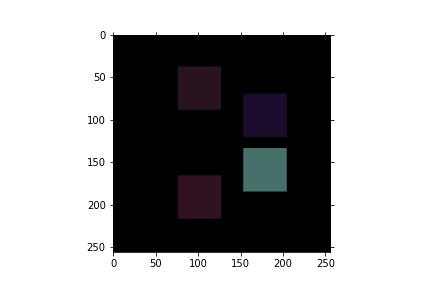

IndexError: index 20 is out of bounds for axis 3 with size 20

In [138]:
import os
import math
import time
import skimage.io as io

eeg_image_size = 256, 256

sensors_xy = {
    "TP9": (.25, 0.4),
    "TP10": (.75, 0.4),
    "AF7": (.375, 0.7),
    "AF8": (.625, 0.7)
}

def band_samples(eeg_data, frame_size=None, sample_rate=DEFAULT_SAMPLE_RATE):
    """
    Create a DataFrame containing all band magnitudes for all sensors
    Returns: DataFrame, shape=(sensor, band, seq_len).
    """
    # Default to 2s per frame
    if frame_size == None:
        frame_size = int(sample_rate * 2)
    # Calculate frame count
    max_frame = len(eeg_data)
    frame_count = int(np.ceil(max_frame / frame_size))
    
    # Create DataFrame
    index_tuples = [list(sensors_xy.keys()), list(eeg_bands.keys())]
    index = pd.MultiIndex.from_product(index_tuples, names=["sensor", "band"])
    df = pd.DataFrame(np.zeros((len(index), frame_count)), index=index)
    
    # Write data
    for sensor_key in sensors_xy.keys():
        raw_eeg = eeg_data[sensor_key]
        raw_eeg = preprocess_eeg(raw_eeg)
        band_samples = band_magnitude_samples(raw_eeg, frame_size, sample_rate)
        for band_key in band_samples.keys():
            df.loc[sensor_key, band_key] = band_samples[band_key]
            
    # Return DataFrame
    return df

def eeg_images(band_samples, size=eeg_image_size):
    """
    Param band_samples: DataFrame, shape=(sensor, band, seq_len).
    Returns ndarray, shape=(size[0], size[1], 4, seq_len)
    """
    imgs = np.zeros((size[0], size[1], 4, len(band_samples)))
    sensor_radius = 0.1
    
    for image_i in range(0, len(band_samples)):
        for sensor_key in sensors_xy.keys():
            x, y = sensors_xy[sensor_key]
            x = int(np.floor(x * size[0]))
            y = int(np.floor(y * size[1]))
            x_range = int(max(0, x-sensor_radius*size[0])), int(min(size[0], x+sensor_radius*size[0]))
            y_range = int(max(0, y-sensor_radius*size[1])), int(min(size[1], y+sensor_radius*size[1]))
            imgs[x_range[0]:x_range[1], y_range[0]:y_range[1], 0, image_i] = band_samples.loc[sensor_key, "Alpha"][image_i]
            imgs[x_range[0]:x_range[1], y_range[0]:y_range[1], 1, image_i] = band_samples.loc[sensor_key, "Beta"][image_i]
            imgs[x_range[0]:x_range[1], y_range[0]:y_range[1], 2, image_i] = band_samples.loc[sensor_key, "Theta"][image_i]
            #imgs[x, y, 3, image_i] = 1.
    
    # Naive scaling
    imgs = imgs / imgs.max()
    # Alpha = 1 for viewing. TODO store additional band?
    imgs[:, :, 3, :] = 1
    
    return imgs

# Create images
bands = band_samples(muse_session_lsd_postpeak)
imgs = eeg_images(band_samples(muse_session_lsd_postpeak))

%matplotlib notebook
# Pick a single image
img = imgs[:, :, :, 0]
# Find indices where r, g, or b value is not zero
sensor_indices = np.array(list(zip(*np.where(img[:, :, 0:2] > 0))))
# Print img info
print(sensor_indices)
print(sensor_indices[0])
print(img[sensor_indices[0][0], sensor_indices[0][1]])
# Setup plot
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()
# Show each image for 1s
for i in range(len(imgs)-1):
    img = imgs[:, :, :, i]
    ax.clear()
    plt.imshow(img)
    #plt.show()
    #plt.legend()
    fig.canvas.draw()
    time.sleep(0.5)

In [8]:
infile = "./data/EEG-10-10.png"
try:
    # Read image
    im = io.imread(infile)
    # Drop alpha
    im = im[:, :, 0:3]
    print(im.shape)
    #im.save(outfile)
except OSError:
    print("cannot convert", infile)

(799, 1200, 3)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTM(nn.Module):
    '''
    FROM: https://github.com/VDelv/EEGLearn-Pytorch
    Build the LSTM model applying a RNN over the 7 parallel convnets outputs
    param input_image: list of EEG image [batch_size, n_window, n_channel, h, w]
    param kernel: kernel size used for the convolutional layers
    param stride: stride apply during the convolutions
    param padding: padding used during the convolutions
    param max_kernel: kernel used for the maxpooling steps
    param n_classes: number of classes
    param n_units: number of units
    return x: output of the last layers after the log softmax
    '''
    def __init__(self, input_image=torch.zeros(1, 7, 3, 32, 32), kernel=(3,3), stride=1, padding=1,max_kernel=(2,2), n_classes=4, n_units=128):
        super(LSTM, self).__init__()

        n_window = input_image.shape[1]
        n_channel = input_image.shape[2]

        self.conv1 = nn.Conv2d(n_channel,32,kernel,stride=stride, padding=padding)
        self.conv2 = nn.Conv2d(32,32,kernel,stride=stride, padding=padding)
        self.conv3 = nn.Conv2d(32,32,kernel,stride=stride, padding=padding)
        self.conv4 = nn.Conv2d(32,32,kernel,stride=stride, padding=padding)
        self.pool1 = nn.MaxPool2d(max_kernel)
        self.conv5 = nn.Conv2d(32,64,kernel,stride=stride,padding=padding)
        self.conv6 = nn.Conv2d(64,64,kernel,stride=stride,padding=padding)
        self.conv7 = nn.Conv2d(64,128,kernel,stride=stride,padding=padding)

        # LSTM Layer
        self.rnn = nn.RNN(4*4*128, n_units, n_window)
        self.rnn_out = torch.zeros(2, 7, 128)

        self.pool = nn.MaxPool2d((n_window,1))
        self.drop = nn.Dropout(p=0.5)
        self.fc = nn.Linear(896, n_classes)
        self.max = nn.LogSoftmax()

    def forward(self, x):
        if x.get_device() == 0:
            tmp = torch.zeros(x.shape[0], x.shape[1], 128, 4, 4).cuda()
        else:
            tmp = torch.zeros(x.shape[0], x.shape[1], 128, 4, 4).cpu()
        for i in range(7):
            img = x[:, i]
            img = F.relu(self.conv1(img))
            img = F.relu(self.conv2(img))
            img = F.relu(self.conv3(img))
            img = F.relu(self.conv4(img))
            img = self.pool1(img)
            img = F.relu(self.conv5(img))
            img = F.relu(self.conv6(img))
            img = self.pool1(img)
            img = F.relu(self.conv7(img))
            tmp[:, i] = self.pool1(img)
            del img
        x = tmp.reshape(x.shape[0], x.shape[1], 4 * 128 * 4)
        del tmp
        self.rnn_out, _ = self.rnn(x)
        x = self.rnn_out.view(x.shape[0], -1)
        x = self.fc(x)
        x = self.max(x)
        return x

# PyTorch EEG Band Model

We will train a PyTorch model on EEG band data, in order to associate with specific actions, emotions, movements, etc.

The first step of this process will be to gather data. To do so, we will use an interactive program which prompts the wearer of the EEG headset to perform specific actions, such as open/close eyes, meditate (guided / unguided), listen to music, ingest a substance, etc. and while the wearer is doing the task, EEG waves are recorded and tagged. We can call a specific session a "survey".

In [168]:
from concurrent.futures import ThreadPoolExecutor
import json # TODO: json survey index file
import pathlib

surveys_top_dir = "./data/muse2-recordings/surveys"

def record_eeg_survey(schedule, survey_tag, survey_desc):
    data_files = []
    timestamp = str(datetime.datetime.now())
    survey_dir = surveys_top_dir + "/Survey " + survey_tag + " " + timestamp
    pathlib.Path(survey_dir).mkdir(parents=True)
    readme_file = survey_dir + "/README.md"
    audio_player_thread = ThreadPoolExecutor(max_workers=1)
    audio_file = "./data/Meditation-bell-sound.mp3"
    play_audio = lambda: os.system("mpg123 " + "./data/Meditation-bell-sound.mp3")
    
    for step, step_i in zip(schedule, range(len(schedule))):
        duration, tag, description, record = step
        full_tag = survey_tag + "_" + str(step_i) + "_" + tag

        # Print desc & play bell
        print(description)
        audio_player_thread.submit(play_audio)
            
        # Record stream or wait
        if record:
            files = save_and_plot_muse_sample_stream(duration,
                                                     tag=full_tag, output_path=survey_dir)
            data_files.append(files)
        else:
            time.sleep(duration.total_seconds())
    
    print("Survey Completed. Thank you.")
    audio_player_thread.submit(play_audio)
    
    readme_text = "# Survey " + survey_tag + "\n\n" + survey_desc + "\n\n" +\
                  "## Schedule\n\n" + str(schedule) + "\n\n"
    
    with open(readme_file, "w") as readme:
        readme.write(readme_text)

Now we will define some sessions.

Just lay down, breathe normally, gently relax any tension
Please start the video and follow the instructions https://www.youtube.com/watch?v=tybOi4hjZFQ


<IPython.core.display.Javascript object>


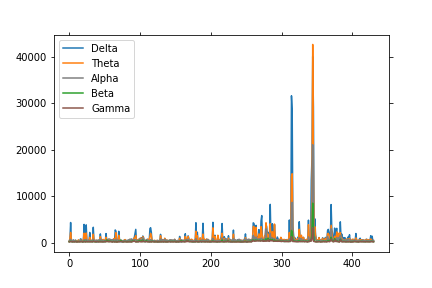

In [ ]:
test_schedule = [
    (datetime.timedelta(seconds=30), "preintro", "Just breathe normally, gently relax any tension", True)
]

short_meditation_schedule = [
    (datetime.timedelta(seconds=30), "preintro", "Just breathe normally, gently relax any tension", False),
    (datetime.timedelta(seconds=30), "intro", "Just breathe normally, gently relax any tension", True),
    (datetime.timedelta(minutes=2), "breath", "Notice the breath", True),
    (datetime.timedelta(minutes=2), "body", "Notice the body", True),
    (datetime.timedelta(minutes=30), "outro", "Open your eyes and become aware of your surroundings", True)
]

smoke_sesh_schedule = [
    (datetime.timedelta(seconds=30), "preintro", "Just breathe normally, gently relax any tension, get in a comfortable position", False),
    (datetime.timedelta(minutes=4), "smoking", "Feel free to smoke as much as possible in four minutes", True),
    (datetime.timedelta(minutes=5), "chill", "Notice any changes in sensation", True)
]

wim_hof_short_vid_schedule = [
    (datetime.timedelta(seconds=30), "preintro", "Just lay down, breathe normally, gently relax any tension", False),
    (datetime.timedelta(minutes=11), "breathing", "Please start the video and follow the instructions https://www.youtube.com/watch?v=tybOi4hjZFQ", True),
    (datetime.timedelta(seconds=30), "outro", "Notice the breath, notice any effects", True),
]

record_eeg_survey(wim_hof_short_vid_schedule, "Wim Hof Short", "A short guided Wim Hof breathing session")

#record_eeg_survey(short_meditation_schedule, "shortmeditation",
#                  "A short 5:30 meditation, starting with the breath, and moving to the body.")

In [128]:
os.system("mpg123 " + "./data/Meditation-bell-sound.mp3")

0

# Scratch

In [ ]:
muse_session_1_raw = pd.read_csv("./data/muse2-recordings/jared/eeg_raw-2021-06-11 14:21:57.792433.csv")
muse_session_1_eeg = pd.read_csv("./data/muse2-recordings/jared/eeg_band_magnitudes-2021-06-11 14:21:57.792433.csv")
muse_session_1_eeg